In [3]:
!pip install numpy pandas scipy


Defaulting to user installation because normal site-packages is not writeable


In [4]:
import sys
!{sys.executable} -m pip install scipy matplotlib


In [5]:
import sys
!{sys.executable} -m pip install pandas


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [7]:
renew = pd.read_csv(
    r"C:\Florence\Campus stuff\Semester 5\Pemodelan Bidang Energi - PBE\TUBES - 11\Data Storage\Final Data\renewable-electricity-Indonesia_2000_2024.csv"
)

nonrenew = pd.read_csv(
    r"C:\Florence\Campus stuff\Semester 5\Pemodelan Bidang Energi - PBE\TUBES - 11\Data Storage\Final Data\non-renewable-electricity-Indonesia_2000_2024.csv"
)

In [8]:
renew_cols = [c for c in renew.columns if "TWh" in c]
nonrenew_cols = [c for c in nonrenew.columns if "TWh" in c]

# Total listrik
renew["Renewable_TWh"] = renew[renew_cols].sum(axis=1)
nonrenew["NonRenewable_TWh"] = nonrenew[nonrenew_cols].sum(axis=1)

In [9]:
df = pd.merge(
    renew[["Year", "Renewable_TWh"]],
    nonrenew[["Year", "NonRenewable_TWh"]],
    on="Year"
)

df["Total"] = df["Renewable_TWh"] + df["NonRenewable_TWh"]
df["s_R"] = df["Renewable_TWh"] / df["Total"]
df["s_N"] = df["NonRenewable_TWh"] / df["Total"]

In [10]:
print(df.head(25))
print("\nCheck s_R + s_N ≈ 1:")
print((df["s_R"] + df["s_N"]).head(25))

    Year  Renewable_TWh  NonRenewable_TWh       Total       s_R       s_N
0   2000      10.020525        156.880000  166.900525  0.060039  0.939961
1   2001      11.650785        167.940000  179.590785  0.064874  0.935126
2   2002       9.930785        184.080000  194.010785  0.051187  0.948813
3   2003       9.100805        195.140000  204.240805  0.044559  0.955441
4   2004       9.670820        207.620000  217.290820  0.044506  0.955494
5   2005      10.833628        220.460000  231.293628  0.046839  0.953161
6   2006      10.134739        233.640000  243.774739  0.041574  0.958426
7   2007      13.816479        248.220000  262.036479  0.052727  0.947273
8   2008      16.677384        259.120000  275.797384  0.060470  0.939530
9   2009      13.130298        272.160000  285.290298  0.046024  0.953976
10  2010      19.700821        285.860000  305.560821  0.064474  0.935526
11  2011      29.007171        322.840000  351.847171  0.082443  0.917557
12  2012      33.121103        355.700

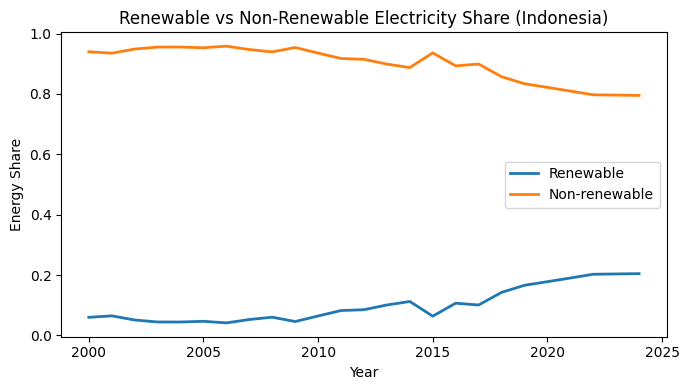

In [11]:
plt.figure(figsize=(7,4))
plt.plot(df["Year"], df["s_R"], label="Renewable", linewidth=2)
plt.plot(df["Year"], df["s_N"], label="Non-renewable", linewidth=2)

plt.xlabel("Year")
plt.ylabel("Energy Share")
plt.title("Renewable vs Non-Renewable Electricity Share (Indonesia)")
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# Estimasi gemma
df["logit_R"] = np.log(df["s_R"] / df["s_N"])
df["logit_N"] = np.log(df["s_N"] / df["s_R"])

t = df["Year"] - df["Year"].min()

gamma_R, gamma0_R = np.polyfit(t, df["logit_R"], 1)
gamma_N, gamma0_N = np.polyfit(t, df["logit_N"], 1)

print("gamma_R =", gamma_R)
print("gamma_N =", gamma_N)

gamma_R = 0.0767292035049421
gamma_N = -0.0767292035049421


In [13]:
h_RN = 1.5   # hambatan fossil terhadap renewable
h_NR = 0.8   # hambatan renewable terhadap fossil

In [14]:
from scipy.integrate import solve_ivp

def energy_competition(t, s):
    sR, sN = s
    dsR = gamma_R * (1 - sR - (1/h_RN)*sN) * sR
    dsN = gamma_N * (1 - sN - (1/h_NR)*sR) * sN
    return [dsR, dsN]

In [15]:
from scipy.integrate import solve_ivp

def energy_competition(t, s):
    sR, sN = s
    dsR = gamma_R * (1 - sR - (1/h_RN)*sN) * sR
    dsN = gamma_N * (1 - sN - (1/h_NR)*sR) * sN
    return [dsR, dsN]

In [16]:
# kondisi awal dari data awal
s0 = [df["s_R"].iloc[0], df["s_N"].iloc[0]]

t_span = (0, len(df)-1)
t_eval = np.linspace(*t_span, 200)

sol = solve_ivp(energy_competition, t_span, s0, t_eval=t_eval)

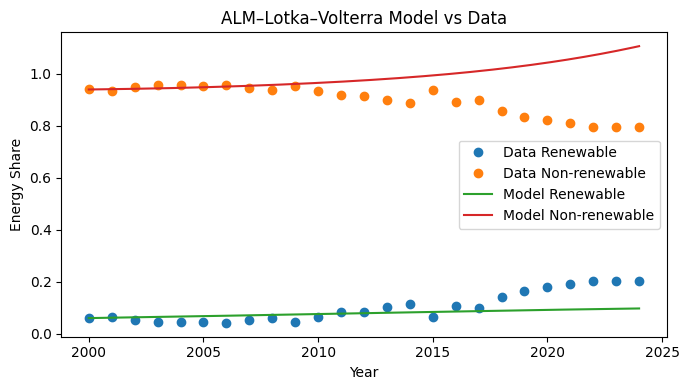

In [17]:
plt.figure(figsize=(7,4))
plt.plot(df["Year"], df["s_R"], 'o', label="Data Renewable")
plt.plot(df["Year"], df["s_N"], 'o', label="Data Non-renewable")

plt.plot(df["Year"].iloc[0] + sol.t, sol.y[0], '-', label="Model Renewable")
plt.plot(df["Year"].iloc[0] + sol.t, sol.y[1], '-', label="Model Non-renewable")

plt.xlabel("Year")
plt.ylabel("Energy Share")
plt.legend()
plt.title("ALM–Lotka–Volterra Model vs Data")
plt.tight_layout()
plt.show()

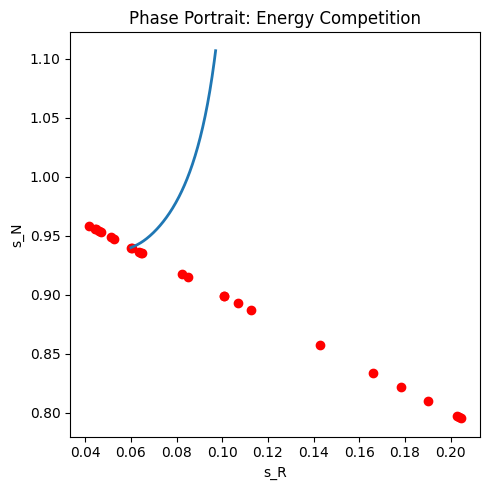

In [18]:
plt.figure(figsize=(5,5))
plt.plot(sol.y[0], sol.y[1], '-', linewidth=2)
plt.scatter(df["s_R"], df["s_N"], c='red')
plt.xlabel("s_R")
plt.ylabel("s_N")
plt.title("Phase Portrait: Energy Competition")
plt.tight_layout()
plt.show()

In [19]:
A = np.array([[1, 1/h_RN],
              [1/h_NR, 1]])

b = np.array([1,1])

s_eq = np.linalg.solve(A, b)
print("Equilibrium (s_R*, s_N*) =", s_eq)

Equilibrium (s_R*, s_N*) = [ 2.  -1.5]
